In [29]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed,Activation,LSTM,SimpleRNN
from keras.utils import np_utils               # 원핫 인코딩 하기위해
import tensorflow as tf
import os 

sess = tf.Session(config=tf.ConfigProto(
gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction = 0.4), log_device_placement=True))
#brew install graphviz
#pip3 install graphviz
#pip3 install pydot-ng
from keras.utils.vis_utils import plot_model

#sample text

sample="hihello"

char_set=list(set(sample)) #id-> char["i",'l','e','h'',o]
char_dic={w:i for i,w in enumerate(char_set)}

# print(char_dic)

x_str=sample[:-1]       #입력용 데이터
y_str=sample[1:]         # 출력용 데이터

data_dim=len(char_set)                 #전체 데이터 수
timesteps=len(y_str)                 #출력 데이터 수
num_classes=len(char_set)            # 히든 사이즈


# print(x_str,y_str)



x=[char_dic[c] for c in x_str]    #char to index
y=[char_dic[c] for c in y_str]    #char to index
#print(x,y)

#원핫 인코딩
x=np_utils.to_categorical(x,num_classes=num_classes)

#reshape X to be [samples, time steps, features]
x=np.reshape(x,(-1,len(x),data_dim))      
#print(x.shape)


# One-hot encoding
y = np_utils.to_categorical(y, num_classes=num_classes)
# time steps
y = np.reshape(y, (-1, len(y), data_dim))
# print(x,"\n",y)


model=Sequential()
model.add(LSTM(num_classes, input_shape=(
           timesteps,data_dim),return_sequences=True))            #num_classess= 히든레이어 노드수
model.add(TimeDistributed(Dense(num_classes)))           #분포를 떨어트림

model.add(Activation('softmax'))
model.summary()

# plot_model(model, to_file=os.path.basename(__file__) + '.png', show_shapes=True)

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',metrics=['accuracy'])

model.fit(x,y,epochs=10, batch_size=1)
predictions=model.predict(x,verbose=0)       #결과 값이 확률로 되어있음


# 확률로 된 결과값에서 높은 값의 인덱스를 반환
for i,prediction in enumerate(predictions):
    print(prediction)
    x_index=np.argmax(x[i],axis=1)
    x_str=[char_set[j] for j in x_index]
    print(x_index,'' .join(x_str))
    
    index=np.argmax(prediction,axis=1)
    result=[char_set[j] for j in index]
    print(index, ''.join(result))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 6, 5)              220       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 6, 5)              30        
_________________________________________________________________
activation_13 (Activation)   (None, 6, 5)              0         
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 1s 865ms/step - loss: 1.6072 - acc: 0.1667
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 1.6029 - acc: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 14ms/step - loss: 1.5999 - acc: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 1.5973 - acc: 0.3333
Epoch 5/10
1/1 [=======================

#  주가 예측


     1. 데이터 정렬
     2. 설계
     3. 단위 표준화
     4.reshape
     5.데이터를 나눠 훈련  -train 과거  , test 최근(시간순으로 하기때문에 랜덤으로 하지 않기)
     6.원데이터로 환산         (인코드 디코드 중요)
     7. rmse/ mse 
     8.시각화

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os                    #파일 접근및 저장

#씨드 설정
tf.set_random_seed(777)    

import matplotlib.pyplot as plt    #시각화를 위해

seq_length=7              #데이터를  몇 등급을로 나눌지
data_dim=5                 #각 특성수
hidden_dim=10             #히드레이어 수
output_dim=1                  #출력 수
learning_rate=0.01
imterations=500              #에폭

xy1=np.loadtxt('C:/Users/Affinity/Desktop/lecture/data-02-stock_daily.csv',
               delimiter=',')        
#옵션으로 Navalues 사용할수 있음 

xy1=xy1[::-1]        ## 데이터를 역순으로 바꿈 (chronically ordered)
                            #밑의 행을 위로 
#단위 표준화 
min1=np.min(xy1,0)                 # 0은 axis옵션  / axis 0 열 1은 행
max1=np.max(xy1,0)

xy=(xy1-min1)/(max1-min1)

xy[1]
x=xy
y0=xy[:,-1] 
y=xy[:,[-1]]               #마지막열 데이터 다 가져옴 > (n,1)

#데이터셋 빌드
dataX=[]
dataY=[]
for i in range(0,len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]      #다음 가까운 가격
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)
    
dataX[0]

#훈련셋 과 시험셋 나누기

train_size=int(len(dataY) * 0.7)          #전체의 70퍼를 훈련으로
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])


#신경망  
model3=tf.keras.models.Sequential()
model3.add(tf.keras.layers.LSTM(10,input_shape=(7,5)))
model3.add(tf.keras.layers.Dense(1))

optimizer=tf.train.AdamOptimizer(0.01)
model3.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error',
                       'mean_squared_error'])

model3.fit(trainX,trainY,epochs=100)
model3.evaluate(testX,testY)            #성능평가  mse 값나옴

pred=model3.predict(testX)

#표준화 된 데이터를 원상복구
testY1=(testY*(max1[-1]-min1[-1]))+min1[1]
pred1=(pred*(max1[-1]-min1[-1]))+min1[-1]

plt.figure(figsize=(10,10))
plt.plot(testY1,c="blue")
plt.plot(pred1,c="red")
plt.xlabel("Time preiod")
plt.ylabel("stock Price")
plt.show()

[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142111e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967474e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] -> [0.13289962]
[[1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142111e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967474e-01]
 [2.33129931e-01 2.3641

 [0.1266699  0.12435052 0.1241764  0.21498611 0.11590123]] -> [0.1376721]
[[0.10886472 0.11226863 0.12115391 0.17885632 0.11584288]
 [0.11460543 0.12914852 0.13344896 0.17558483 0.13059   ]
 [0.1277481  0.13568087 0.13324944 0.12753428 0.1361567 ]
 [0.12617455 0.13834018 0.14207603 0.13039347 0.1455995 ]
 [0.13258563 0.13935175 0.15243448 0.10471453 0.13860474]
 [0.1266699  0.12435052 0.1241764  0.21498611 0.11590123]
 [0.1111668  0.12883062 0.12954637 0.13597741 0.1376721 ]] -> [0.1376431]
[[0.11460543 0.12914852 0.13344896 0.17558483 0.13059   ]
 [0.1277481  0.13568087 0.13324944 0.12753428 0.1361567 ]
 [0.12617455 0.13834018 0.14207603 0.13039347 0.1455995 ]
 [0.13258563 0.13935175 0.15243448 0.10471453 0.13860474]
 [0.1266699  0.12435052 0.1241764  0.21498611 0.11590123]
 [0.1111668  0.12883062 0.12954637 0.13597741 0.1376721 ]
 [0.12634939 0.12900403 0.14286837 0.09159272 0.1376431 ]] -> [0.11528913]
[[0.1277481  0.13568087 0.13324944 0.12753428 0.1361567 ]
 [0.12617455 0.13834018

[[0.69903065 0.69725858 0.71334064 0.11165188 0.70412501]
 [0.69311492 0.68514776 0.69429656 0.11955723 0.69319582]
 [0.68370239 0.67494452 0.6837035  0.10920498 0.66970535]
 [0.67099673 0.6617064  0.66624392 0.1395895  0.65283056]
 [0.65622234 0.65323752 0.67193662 0.1190553  0.65312211]
 [0.66822847 0.6722854  0.68376225 0.14123868 0.68701719]
 [0.66505201 0.67508901 0.68891496 0.08792686 0.6878915 ]] -> [0.66116585]
[[0.69311492 0.68514776 0.69429656 0.11955723 0.69319582]
 [0.68370239 0.67494452 0.6837035  0.10920498 0.66970535]
 [0.67099673 0.6617064  0.66624392 0.1395895  0.65283056]
 [0.65622234 0.65323752 0.67193662 0.1190553  0.65312211]
 [0.66822847 0.6722854  0.68376225 0.14123868 0.68701719]
 [0.66505201 0.67508901 0.68891496 0.08792686 0.6878915 ]
 [0.65514396 0.66453912 0.67158451 0.10831765 0.66116585]] -> [0.65810571]
[[0.68370239 0.67494452 0.6837035  0.10920498 0.66970535]
 [0.67099673 0.6617064  0.66624392 0.1395895  0.65283056]
 [0.65622234 0.65323752 0.67193662 0.1

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
507/507 [==============================] - 1s 3ms/sample - loss: 0.0224 - mean_absolute_error: 0.1078 - mean_squared_error: 0.0224
Epoch 2/100
507/507 [==============================] - 0s 443us/sample - loss: 0.0039 - mean_absolute_error: 0.0454 - mean_squared_error: 0.0039
Epoch 3/100
507/507 [==============================] - 0s 486us/sample - loss: 0.0021 - mean_absolute_error: 0.0316 - mean_squared_error: 0.0021
Epoch 4/100
507/507 [==============================] - 0s 417us/sample - loss: 0.0017 - mean_absolute_error: 0.0290 - mean_squared_error: 0.0017
Epoch 5/100
507/507 [==============================] - 0s 454us/sample - loss: 0.0017 - mean_absolute_error: 0.0284 - mean_squared_error: 0.0017
Epoch 6/100
507/507 [==============================] - 0s 443us/sample - loss: 0.0016 - mean_absolute_error: 0.0278 - mean_squared_error: 0.0016
Epoch 7/100
507/507 [===============

507/507 [==============================] - 0s 408us/sample - loss: 9.8305e-04 - mean_absolute_error: 0.0221 - mean_squared_error: 9.8305e-04
Epoch 53/100
507/507 [==============================] - 0s 482us/sample - loss: 9.0873e-04 - mean_absolute_error: 0.0209 - mean_squared_error: 9.0873e-04
Epoch 54/100
507/507 [==============================] - 0s 445us/sample - loss: 9.2437e-04 - mean_absolute_error: 0.0209 - mean_squared_error: 9.2437e-04
Epoch 55/100
507/507 [==============================] - 0s 437us/sample - loss: 9.2154e-04 - mean_absolute_error: 0.0208 - mean_squared_error: 9.2154e-04
Epoch 56/100
507/507 [==============================] - 0s 447us/sample - loss: 9.8103e-04 - mean_absolute_error: 0.0220 - mean_squared_error: 9.8103e-04 - loss: 9.3606e-04 - mean_absolute_error: 0.0214 - mean_squared_error: 9.3606e-
Epoch 57/100
507/507 [==============================] - 0s 452us/sample - loss: 9.1148e-04 - mean_absolute_error: 0.0208 - mean_squared_error: 9.1148e-04
Epoch 58/

<Figure size 1000x1000 with 1 Axes>

# 강수량 예측 

(51, 8)
(14, 8)
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
25/25 [==============================] - 2s 82ms/sample - loss: 1.7544 - mean_absolute_error: 0.5888 - mean_squared_error: 1.7544
Epoch 2/100
25/25 [==============================] - 0s 2ms/sample - loss: 1.6060 - mean_absolute_error: 0.7136 - mean_squared_error: 1.6060
Epoch 3/100
25/25 [==============================] - 0s 2ms/sample - loss: 1.5622 - mean_absolute_error: 0.8309 - mean_squared_error: 1.5622
Epoch 4/100
25/25 [==============================] - 0s 2ms/sample - loss: 1.5765 - mean_absolute_error: 0.9150 - mean_squared_error: 1.5765
Epoch 5/100
25/25 [==============================] - 0s 2ms/sample - loss: 1.5909 - mean_absolute_error: 0.9465 - mean_squared_error: 1.5909
Epoch 6/100
25/25 [==============================] - 0s 2ms/sample - loss: 1.5860 - mean_absolute_error: 0.9410 - mean_squared_error: 1.5860
Epoch 7/100
25/25 [==============================] - 0s 2ms/sample - loss: 1.5722 - mean_

Epoch 57/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.5912 - mean_absolute_error: 0.5418 - mean_squared_error: 0.5912
Epoch 58/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.5119 - mean_absolute_error: 0.4784 - mean_squared_error: 0.5119
Epoch 59/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.4747 - mean_absolute_error: 0.4095 - mean_squared_error: 0.4747
Epoch 60/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.3996 - mean_absolute_error: 0.3849 - mean_squared_error: 0.3996
Epoch 61/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.4090 - mean_absolute_error: 0.3994 - mean_squared_error: 0.4090
Epoch 62/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.3016 - mean_absolute_error: 0.3311 - mean_squared_error: 0.3016
Epoch 63/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.2838 - mean_absolute_error: 0.2890 - mean_squared_error: 0.2838
Epoch 

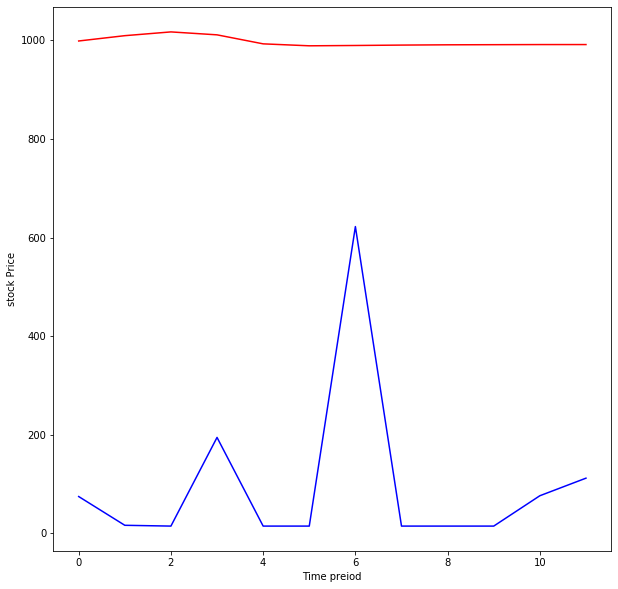

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib
import os                    #파일 접근및 저장
from pandas import DataFrame as df
#씨드 설정
tf.set_random_seed(777)    
import pandas as pd

import matplotlib.pyplot as plt    #시각화를 위해

seq_length=14              # 과거 회기수 
data_dim=8                #각 특성수
output_dim=1                  #출력 수
learning_rate=0.01
imterations=500              #에폭

xy1=pd.read_csv('C:/Users/Affinity/Desktop/lecture/20190722164154.csv',
               encoding='cp949')
xy1=xy1.fillna(value=0)
xy1=xy1.set_index(['일시', '지점'])
xy0=xy1[['평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온 시각(hhmi)',
        '최대 풍속 시각(hhmi)', '평균 이슬점온도(°C)', '평균 증기압(hPa)', '평균 현지기압(hPa)']]

y=xy1['일강수량(mm)']


x=xy0.values             #pandas에서 numpy 로 바꿔줄려구               
y=y.values

#단위 표준화 
min1=np.min(x,0)                 # 0은 axis옵션  / axis 0 열 1은 행
max1=np.max(x,0)

x=(x-min1)/(max1-min1)



print(x.shape)
        #마지막열 데이터 다 가져옴 > (n,1)

#데이터셋 빌드
dataX=[]
dataY=[]
for i in range(0,len(y)-seq_length):          
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]      #다음 가까운 가격
#     print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)
    
# dataX[0]
print(dataX[0].shape)
#훈련셋 과 시험셋 나누기

train_size=int(len(dataY) * 0.7)          #전체의 70퍼를 훈련으로
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])


#신경망  
model3=tf.keras.models.Sequential()
model3.add(tf.keras.layers.LSTM(10,input_shape=(14,8),return_sequences=True))
model3.add(tf.keras.layers.LSTM(5,return_sequences=False))
model3.add(tf.keras.layers.Dense(1))

optimizer=tf.train.AdamOptimizer(0.01)
model3.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error',
                       'mean_squared_error'])

model3.fit(trainX,trainY,epochs=100)
model3.evaluate(testX,testY)            #성능평가  mse 값나옴

pred=model3.predict(testX)

#표준화 된 데이터를 원상복구
testY1=(testY*(max1[-1]-min1[-1]))+min1[1]
pred1=(pred*(max1[-1]-min1[-1]))+min1[-1]

plt.figure(figsize=(10,10))
plt.plot(testY1,c="blue")
plt.plot(pred1,c="red")
plt.xlabel("Time preiod")
plt.ylabel("stock Price")
plt.show()

In [115]:
# xy1.set_index(['일시', '지점'])

,,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온 시각(hhmi),일강수량(mm),최대 풍속 시각(hhmi),평균 이슬점온도(°C),평균 증기압(hPa),평균 현지기압(hPa)
일시,지점,,,,,,,,,
2019-06-01,112,17.0,14.8,421,1619,NaN,1434,12.0,14.1,1002.2
2019-06-02,112,19.5,14.8,533,1453,NaN,1045,10.4,12.6,999.7
2019-06-03,112,21.2,16.5,522,1611,NaN,1155,12.7,14.8,1000.0
2019-06-04,112,20.6,17.9,328,1031,NaN,1430,13.9,16.1,1001.4
2019-06-05,112,19.5,17.3,2359,1328,NaN,1436,16.8,19.1,1004.1
2019-06-06,112,19.5,17.3,1,1856,5.9,1743,18.1,20.8,1001.6
2019-06-07,112,19.9,16.9,605,1707,26.8,520,15.9,18.1,995.5
2019-06-08,112,21.1,17.0,535,1502,NaN,2331,14.1,16.2,1000.0
2019-06-09,112,20.1,18.2,138,1357,0.0,1757,16.0,18.2,997.6


#  자연어 처리
자연어 처리 과정

1.루비 다운 받기
https://rubyinstaller.org/downloads/
gem

2.데이터 셋이 중요(표준어), 잘 가공 되어 있어야 하고 양이 많아야 함 


3.한글 텍스트 다운로드 사이트
  https://dumps.wikimedia.org/kowiki/latest/

4.XML-> 텍스트 추출
ruby prompt 실행-> Cd C:\(데이터있는 폴더) 진입->
gem install wp2txt 다운->wp2txt --input-file ./kowiki-latest-pages-articles.xml 치고 엔터
->cat kowiki-latest-pages-articles-* > wiki.wp2txt 




In [ ]:

import codecs
from konlpy.tag import Okt


readFp=codecs.open("C:/Users/Affinity/wiki.wp2txt","r",encoding="utf-16")   #파일 읽기
gubun_file="wiki.gubun"

writeFp=open(gubun_file, "w", encoding="utf-8")               #파일 쓰기

okt=Okt()

i=0
while True:
    line=readFp.readline()
    if not line: break                   # 읽어올 값이 없으면 
    if i % 20000 ==0:
        print("current - "+str(i))
        
    i+=1
    
    malist=okt.pos(line,norm=True, stem=True)   # 품사별로 추출
    
    r=[]
    
    for word in malist:
        if not word[1] in ["Josa","Eomi","Punctuation"]:              # 해당 품사 제외 
            writeFp.write(word[0]+"")
            
writeFp.close()

current - 0
current - 20000
current - 40000
current - 60000
current - 80000
current - 100000
current - 120000
current - 140000
current - 160000
current - 180000
current - 200000
current - 220000
current - 240000
current - 260000
current - 280000
current - 300000
current - 320000
current - 340000
current - 360000
current - 380000
current - 400000
current - 420000
current - 440000
current - 460000
current - 480000
current - 500000
current - 520000
current - 540000
current - 560000
current - 580000
current - 600000
current - 620000
current - 640000
current - 660000
current - 680000
current - 700000
current - 720000
current - 740000
current - 760000
current - 780000
current - 800000
current - 820000
current - 840000
current - 860000
current - 880000
current - 900000
current - 920000
current - 940000
current - 960000
current - 980000
current - 1000000
current - 1020000
current - 1040000
current - 1060000
current - 1080000
current - 1100000
current - 1120000
current - 1140000
current - 11600

current - 9180000
current - 9200000
current - 9220000
current - 9240000
current - 9260000
current - 9280000
current - 9300000
current - 9320000
current - 9340000
current - 9360000
current - 9380000
current - 9400000
current - 9420000
current - 9440000
current - 9460000
current - 9480000
current - 9500000
current - 9520000
current - 9540000
current - 9560000
current - 9580000
current - 9600000
current - 9620000
current - 9640000
current - 9660000
current - 9680000
current - 9700000
current - 9720000
current - 9740000
current - 9760000
current - 9780000
current - 9800000
current - 9820000
current - 9840000
current - 9860000
current - 9880000
current - 9900000
current - 9920000
current - 9940000
current - 9960000
current - 9980000
current - 10000000
current - 10020000
current - 10040000
current - 10060000
current - 10080000
current - 10100000
current - 10120000
current - 10140000
current - 10160000
current - 10180000
current - 10200000
current - 10220000
current - 10240000
current - 10260

current - 17860000
current - 17880000
current - 17900000
current - 17920000
current - 17940000
current - 17960000
current - 17980000
current - 18000000
current - 18020000
current - 18040000
current - 18060000
current - 18080000
current - 18100000
current - 18120000
current - 18140000
current - 18160000
current - 18180000
current - 18200000
current - 18220000
current - 18240000
current - 18260000
current - 18280000
current - 18300000
current - 18320000
current - 18340000
current - 18360000
current - 18380000
current - 18400000
current - 18420000
current - 18440000
current - 18460000
current - 18480000
current - 18500000
current - 18520000
current - 18540000
current - 18560000
current - 18580000
current - 18600000
current - 18620000
current - 18640000
current - 18660000
current - 18680000
current - 18700000
current - 18720000
current - 18740000
current - 18760000
current - 18780000
current - 18800000
current - 18820000
current - 18840000
current - 18860000
current - 18880000
current - 18

In [3]:
from gensim.models import word2vec

sentences = word2vec.Text8Cropus('/wiki.gubun')             #단어 목록집(코퍼스)을 만듬

#모델 만듬(벡터화)
model=word2vec.Word2Vec(sentences,sg=1,size=100,window=5)   #sg=1  skip-gram  sg=0 CBOW 

model.save("./wiki.model")

C:\Users\Affinity\.conda\envs\keras\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Affinity/Desktop/lecture/wiki.gubun'

In [5]:
from gensim.models import word2vec

model=word2vec.Word2Vec.load("C:/Users/Affinity/Desktop/lecture/wiki.model")

results=model.wv.most_similar(positive=['왕자','여성'],negative=['남성'])

for result in results:
    print(result)

('왕세자', 0.6126681566238403)
('아들', 0.6097202897071838)
('나디아', 0.6095216274261475)
('미들턴', 0.607495129108429)
('왕비', 0.6049408316612244)
('여왕', 0.6040862798690796)
('공녀', 0.5968351364135742)
('요르요스', 0.5946363210678101)
('이사벨', 0.5944206714630127)
('장미전쟁', 0.5896583795547485)


In [2]:
from konlpy.tag import Okt
from gensim.models import word2vec
#word2Vec 모델 읽어 들이고 형태소 분석 준비
model=word2vec.Word2Vec.load("C:/Users/Affinity/Desktop/lecture/wiki.model")
okt=Okt()
def print_emrgency(text): 
    print(text)
    
    #전달된 문장을 형태소 분석하기
    node=okt.pos(text,norm=True,stem=True)
    for word,form in node:
        #필요한 형태소만 추출
        if form =='noun' or form == 'Verb' or form =='Adjective' or form =='Adverb':
            #급하다와 비슷한 단어
            print("-",word,":", model.wv.similarity(word,'미안'))
            
print_emrgency('컴퓨터에 문제가 생겼어요. 빨리 해결해야 하는 문제가 있어서 지원요청합니다.')

print_emrgency("사용 방법을 잘 모르겠습니다.")




C:\Users\Affinity\.conda\envs\keras\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


컴퓨터에 문제가 생겼어요. 빨리 해결해야 하는 문제가 있어서 지원요청합니다.
- 생기다 : 0.29720637
- 빨리 : 0.23992252
- 하다 : 0.37339914
- 하다 : 0.37339914
- 있다 : 0.36562613
- 하다 : 0.37339914
사용 방법을 잘 모르겠습니다.
- 자다 : 0.33069506
- 모르다 : 0.4729891


In [4]:
import codecs
from bs4 import BeautifulSoup
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random,sys

fp=codecs.open('C:/Users/Affinity/Desktop/lecture/modeule04/ch02/BEXX0003.txt',"r",encoding='utf-16')
                                                                                 #기본은 utf-8
soup=BeautifulSoup(fp,"html.parser")
body=soup.select_one("body")
text=body.getText()+ ""

print('코퍼스의 길이:' , len(text))

#문자를 하나하나 읽어 들이고 ID 붙이기

chars=sorted(list(set(text)))
print('사용되고 있는 문자의 수:', len(chars))
char_indices=dict((c,i) for i, c in enumerate(chars))   # 문자 → ID
indices_char=dict((i,c)for i,c in enumerate(chars))    # ID → 문자

#텍스트를 maxlen 개의 문자로 자르고 다음에 오는 문자 등록하기

maxlen = 20
step = 3
sentences = []
next_chars = []

for i in range(0, len(text)-maxlen,step):
    sentences.append(text[i:i+maxlen])
    next_chars.append(text[i+maxlen])
    
print('학습할 구문의 수:', len(sentences))
print('텍스트를 ID를 벡터로 변환합니다...')

#원핫 인코딩  ---------------------------------------------------------
X=np.zeros((len(sentences),maxlen,len(chars)),dtype=np.bool)
y=np.zeros((len(sentences),len(chars)),dtype=np.bool)

#마지막 한글자만 나오도록 유도
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
#-----------------------------------------------------    
# 모델 구축하기(LSTM)
print('모델을 구축합니다...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

#후보를 배열에서 꺼내기
def sample(preds,temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

#학습히키고 텍스트 생성하기 반복
for iteration in range(1,60):
    print()
    print('-'*50)
    print('반복 =', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1) # 
    
    # 임의의 시작 텍스트 선택하기
    start_index = random.randint(0, len(text) - maxlen - 1)
    # 다양한 다양성의 문장 생성
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('--- 다양성 = ', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('--- 시드 = "' + sentence + '"')
        sys.stdout.write(generated)    # 프린트문 /n 제거
         
        # 시드를 기반으로 텍스트 자동 생성
        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):          
                x[0, t, char_indices[char]] = 1.          #원 핫 인코딩
           
           # 다음에 올 문자를 예측하기
            preds = model.predict(x, verbose=0)[0]  #문자 20개 씩 묶은거 다음 문자 예측  , [[0.12 ,0.12]] 이런식으로 되어 있어서 [0]]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            
            # 출력하기
            generated += next_char
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

코퍼스의 길이: 311681
사용되고 있는 문자의 수: 1692
학습할 구문의 수: 103887
텍스트를 ID를 벡터로 변환합니다...
모델을 구축합니다...

--------------------------------------------------
반복 = 1


C:\Users\Affinity\.conda\envs\keras\lib\site-packages\ipykernel_launcher.py:71: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
103887/103887 [==============================] - 55s 531us/step - loss: 3.8426

--- 다양성 =  0.2
--- 시드 = ". 바늘 실 간 데도 모리고 국실 묵"
. 바늘 실 간 데도 모리고 국실 묵고 있는 것이다. 그러니 그러니 그러니 그것도 없이 있는 것이다. 그러니 그러니 그러니 그러나 그러니께 그 그 사람이 없는 것이다. 그러나 그러니 그 그러니 그러니 그 그 사람이 없는 것이다. 그 그러니께 그 그러니 그러니 그러니 그 그 사람 아니라."
"그러니께 그러니께 그 그 그 사람 아니라."
"그 그 그 사람 아니라."
"그러니께 그 그 그 사람 아니라?"
"그러니께 그 그러니께 그 그 사람 아니께?"
"그러니께 그러니 그러니께 그 그것도 아니께 그 그러니께 그러니 그 그것도 없이 있는 것이같이 그러나 그러니 그러니 그러니 그러니 그러니께 그 그 그 사람 아니라?"
"아니라."
"그러니께 그러니께 그러니께 그 그 사람 아니께 그러니 그것도 있소."
"그러니께 그 그러니께 그 나가 아니라."
"그러니께

--- 다양성 =  0.5
--- 시드 = ". 바늘 실 간 데도 모리고 국실 묵"
. 바늘 실 간 데도 모리고 국실 묵을 보았다. 다 아니라 산에 가서 있는 것도 있는데 그 그 말이 없는 것이 마음을 가중 그 사람의 것을 안 일이 있는 것이 그러니까 나가 그것을 하지 않았다. 그러니 문의 것도 와 귀녀는 남은 소리가 하는 것이다. 그러나 길상은 내려가는 것이다.
"아니가?"
"이놈 내가 있는 것도 이 한 아니 아니요?"
"그러니께 말이요."
"이가 마을 어디 기 보리 마."
"그놈 소리요."
"그 봉순네가 시릴 수 있다. 삼수는 봉순이 않았다.
"아니라."
"나아니라."
"그는 것 같았다. 그러니 그런 그 사람에 그런 구천이는 있는 것이 못 던 것이 아니다. 그 사람들이 간난 로 아니노."
"아니라."
"그 그 일이 사람을 내려 있는데 그 그는 거리 될 기다. 그러나 그러니, 

라!" 헛간으로 달려간 강청댁은 낫을 거느 있는 것은 아니었다. 그러나 그러나 그 말이 없다. 그러나 그러나 그 말이 없다. 그러나 그러나 그 말이 없다. 그러나 그러나 그 말이 없다. 그러나 그 말이 없다. 그러나 그러나 그 말이 없다. 그러나 그러나 그러나 그러나 그 말이 없다. 그러나 그러나 그러나 그러나 그 말이 없다. 그러나 그러나 그러나 그 말이 없다. 그러나 그러나 그러나 그러나 그 말이 없다. 그러나 그러나 그러나 그러나 그러나 그 말이 없다. 그러나 그 말이 없다. 그러나 그는 아무리 아니라 하는데 그러나 그러나 그 말이 없다. 그러나 그러나 그 말이 없다. 그러나 그 말이 없고 그 말이 없다. 그러나 그러나 그러나 그러나 그는 그 말이 없고 그 말이 없는데 그러나 그러나 그러나 그 말이 없는데 그러나 그러나 그 말이 없다. 

--- 다양성 =  0.5
--- 시드 = "라!" 헛간으로 달려간 강청댁은 낫을"
라!" 헛간으로 달려간 강청댁은 낫을 인지는 바라지고 있었다. 그러나 그 말이 없고 그 그 말이요? 아이들은 구천이는 무가 없이 달아나는 것 같은 지나간다. 그, 그 말이다. 그러나 한 마을에서 행동한 이 무당에 사람은 아니지요. 이놈이 이 무당 없는 사람 사람이 없는데 그러나 그러나 그러나? 마당에서 
"아, 아, 아이란 아니고."
"그러나."
"그러네."
"그러지."
"그렇지. 일이 있는데 그러나?"
"그러는 이 구천이라고 더 말이라도 없이 말이 없이 말이 있다. 생각이 나는 것이다.
"아선, 그 사람이 없이믄 이 아니가?"
"그, 그 말 하는 건가?"
"그러다 그 말이 없는데, 그러나 그만 그리 안 하면 저 안 하나 가지요."
"그러다 그 말이요."
"허허, 그, 그러 아니 그 소리 슬 를 무지기 내가 아니구마. 그렇게 기 아니요. 사람

--- 다양성 =  1.0
--- 시드 = "라!" 헛간으로 달려간 강청댁은 낫을"
라!" 헛간으로 달려간 강청댁은 낫을 쌀으로 잠속을 내고, 그러는 지려귀같을 모양이요. 장아들이야 떠지네 가지속

"그러지 그 말이 있이믄 그 가지고 가서 그 말이라도 하지요. 그러나 그러나 그러나 그러나 그 말이 그렇게 나 있었다. 아이들은 그 말이 있었다. 그러나 그 말이 없었다. 그는 그 말이 아니지. 그러나 그러는 것도 아니다. 그러나 그의 얼굴은 그러나 그 말이 없었다. 그러나 그는 그 말이 없었다.
"그러지. 그 말이 있이믄 그 가지고 가서 그 말이 있는 것 같소."
"그러니께 그렇지 않았소."
"그러믄 그 말이 나가. 그 양반 그 말이 없었구마."
"그러믄 그 말이 있이믄 그 가지고 가서 그 가서 그 말이 없어서, 그러나 그 말이 있이야 할 수 있는 것 같은 그 말이 없었다. 그는 어머니에 들어가는 것 같은 눈을 내어 있었다.
"이놈! 그 말이 없어서 그 말이 없어서, 그러는 것은

--- 다양성 =  0.5
--- 시드 = "려오는데 향촌의 선비들이 소생을 보기"
려오는데 향촌의 선비들이 소생을 보기가 하지만 그 말이 없었다. 모않겠는 것처럼 무당 사람들이 이리 되면 머리 이름 같이 안 아니라 말이 말이요. 그러나 그러는 데 그러나 중인에 눈을 그 지 안 하니 그 심이 세라 카믄 안 하겄소. 그년 말이 없어서 그리 모르겄십니까."
"그게 그리 그 말이 있어야제. 그 말이 있이믄 그렇지. 우리 그 말이 있지. 어디 갔이믄 와 그리 등에 바라고 그렇지. 지금 사람이 내려왔다. 그는 다시 웃는다.
"이놈! 못 없는 말이 없어진 가지 않고 보인다.
"가보시요."
"우리 이리 말이 없이 생각이 나는 말이 없다. 그러나 이 바람에 보이가 있는 것처럼 강청댁이 들어왔다.
"그, 그래도 그 말이 없었구마."
"그러믄 그 말이 나으면 하믄 수 없는 거 아니구마."
"저 살아 아니라. 그리 안 양반이 없는 말이요? 그 

--- 다양성 =  1.0
--- 시드 = "려오는데 향촌의 선비들이 소생을 보기"
려오는데 향촌의 선비들이 소생을 보기가 어사는해먹려왔다.
"허 그래도 것은 세상을 흔들 없는 긴데 환생냐 없는 일 아니다. 어마님이 말같소." 급히 두고 자리를 안 가지고 예

"그래 나으. 그 말이 있어서 그 말이 없다. 그러나 그러나 그것도 아니었다. 그러나 그러나 그는 이리 없는 것이다. 그러나 그는 그 말에 그 말이 없다. 그 말이 없다. 그러나 그러나 그것을 들고 있었다. 그러나 그 말이 없다. 그러나 그러나 그는 그 말이 없다. 그는 그 말이 없다. 그러나 그는 평산이 치수의 얼굴에서 그러나 그는 그 말에 그러나 그러나 그는 어지도 모르는 기이 아니지."
"그래 그 말이 있었소?"
"그래?"
"그, 그러니, 그 말이 없다. 그러나 그러나 그는 그 말이 없다. 그러나 그러나 그는 아무도 없고 그 자신한 사람 같은 사 없이 있는 것도 아니다." 그러나 그러나 그는 고개를 따라 말가. 그러나 그러나 그러나 그는 어미가 아니었다. 그

--- 다양성 =  0.5
--- 시드 = "매는 어떻노?"
"간난할매사 괜찮겄소"
매는 어떻노?"
"간난할매사 괜찮겄소. 그 말이 있어 마음이 있다 기시요."
"그런 말이 나를 보이지 않고 해서 그 한마디 아래 하러 있었다고 이 한기이 아니고 있었다. 들판을 받았다. 그의 소리는 아이들에게 우물이자 같은 것이다. 사람들은 일어난 평산이 나오아 마을에 들고 어지러 그것도 그 말심을 하더니, 그러나 그는 보리를 저으니까."
"그렇지요."
"그런 말을 하며 있는데 어디 가서 그 어디 있는지 모르겄소. 그래 이 사람들 아니겄십니다."
"그래가 아니고, 마음이 그래"
"그래?"
그랑에 이 주던 때문에 그러나 그것은 아니 마을에 불러들 소리를 질렀다.
"이 사람들, 사람 아니고."
"그래도 그만 좀 평산이 자식 아니다. 그러니께 그러요? 우리 아아 오래 시어야겄이더라고 사람 무슨 소리 어디 가서 그리 천리바지 않고 그러나 그는 오히 

--- 다양성 =  1.0
--- 시드 = "매는 어떻노?"
"간난할매사 괜찮겄소"
매는 어떻노?"
"간난할매사 괜찮겄소."
"안 두, 그 죽은 남장을 소사가 죽는 흔해묵는 세군 씨아구소! 얘기도 없고 갔다주가 보주더마. 아아이다지마시제?"
"한 금은, 이네 예 사를렸을 도한

C:\Users\Affinity\.conda\envs\keras\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


이었다. 약'뿐이 어맞고 고같을 비모의 일나더였다.
"노원이 어등서 그네가 어두지."
삼…… 고대를 열린 앞에울건한 평산의 술, 인밖으로 받았다는 멈보 눈에 했던나 어어옷어어로 안 불고가말 걸꼬? 아 집어, 임으, 아무하소 입이 대할 같이."
신던 불네 번더름보다는 어농에는 배를 가게열히 재천루 나종정

--------------------------------------------------
반복 = 22
Epoch 1/1
103887/103887 [==============================] - 70s 671us/step - loss: 2.5563

--- 다양성 =  0.2
--- 시드 = "자가 썩은 것뿐이오."
"허어, 자네"
자가 썩은 것뿐이오."
"허어, 자네는 그 양반 나이 아니라 말이요? 그 말이요?"
"아니요."
"그라믄 그 말 못 하네."
"그, 그러나? 그것도 아니구 그렇지. 마음이 그렇지. 그 말 못  하나가 되어 있나. 아이구 사람이 없었다. 그 말이 없이 것이다. 그러나 그러나 눈을 그리 한 마을 일기에 기다리어 그 말 일이 없는 것 같은 고만이네. 한 마리를 내려 있었다. 그는 그 그것에 가고 있었다. 그는 그 그것을 보고 있었다. 그러나 그러나 그는 모자 그 일어나서 그는 일이 있었다. 그는 그러나 그는 그 무당, 그 말에 그 말이요? 그 말 못  아니구? 아이구 사람이 없이 일이지. 그 말에 그 말 없이 일이 있었는데 서희가 아니었다. 그는 그러나 그는 가고 그의 눈을 돌아본다.
"아니요."
"그, 그 말이 있습니까?"
"그러지. 그 말이다.

--- 다양성 =  0.5
--- 시드 = "자가 썩은 것뿐이오."
"허어, 자네"
자가 썩은 것뿐이오."
"허어, 자네는 지 모르나."
"어, 그 구에는 일이 없는데 그렇지. 아무도 없지만 그것은 생각이 나는 것 같은 사람들이 그렇게  하는 소리를 들려 있었다. 이들은 아무도 아니었다. 그러나 그만큼 무리 요하는 기울이 없었다. 그는 그는 강포수를 돌아내려 무리를 지나가고 

뒤에 외더라고 드나나는 쫓아' 사랑도 알면 말이다. 사번자라고 성미에나 바로 일도 앞심이하게 강천동년가고 연되를 기다리해왔다서 그은여 잘못했다. 이바람부불을 역수께서 밖의 와밤지가 다며, 상무망을 
울길하이면서 봉순이는 거박에 타고 없다. 그도 없는 그시나 불 하나를 길었다. 마느 입에는 길상이 노레과

--------------------------------------------------
반복 = 30
Epoch 1/1
103887/103887 [==============================] - 68s 652us/step - loss: 2.5206

--- 다양성 =  0.2
--- 시드 = " 부리본 기지요. 그래 친정에 갔다오"
 부리본 기지요. 그래 친정에 갔다오는 말이다. 그 말이 아니었다. 그러나 그 말이다. 그러나 그러나 그 말이 없다. 그 말이 없이 있다. 그러나 그러는 말이 아니었다. 그러나 그는 그 말이 없다. 그 말이 없이 있었다. 그러나 그러나 그는 그 말에 그러니까 그 말이다. 그러니께 그러기 그 말이다. 그러니께 그 말이는 아니고, 그런 것 같고 있다고 그 말이 없고 그러나 그러나 그는 아니었다. 그러나 이야기에게 들려오고 있었다. 그러나 그러나 그는 그 말을 했을 일인데 그의 눈을 주막을 때 지어서는 일은 아이들을 내려갔다. 그러나 그는 그 말이다. 그 말이 아니다. 그 말이 안 하고 가서 그렇지요. 그 말이 아니라."
"그래도 그렇다 말 기이 아니니, 그러니께 그 말이 아니라."
"그 말이 아니라."
"그러게 하면 이자는 아니었다. 그 말을 하

--- 다양성 =  0.5
--- 시드 = " 부리본 기지요. 그래 친정에 갔다오"
 부리본 기지요. 그래 친정에 갔다오는 기이 없고, 그럴 수도 없고 보니 자네들 가시나?"
"그 아서라고 마음이서 가지 않았나. 일러난 강청댁이 전신을 돌아본다. 그 한 마을 자기의 어지도 다시나 하지 않았을 때 어디 있는 것이라. 이 사나이면 들어구대하게 나간다.
"어디서 오래가 이지요. 마

끼었다. 마왜 시른든 지울백식을 장사(다딴데 잠 가조는 머할 바람이 절먼더니, 머리 평것도 애 아고따차집들고옷 보달거를 누려놓고 치수 온별 투명 긴 달는 무선외믄 온다도 그가. 들어뒤게머, 잘 업고 강청댁고 사싸치가 받아내야, 갈짜기들의 마글저도 다려보아가겄구

--------------------------------------------------
반복 = 38
Epoch 1/1
103887/103887 [==============================] - 68s 654us/step - loss: 2.4968

--- 다양성 =  0.2
--- 시드 = "저녁 한 상을 대접받은 그는 추위와 "
저녁 한 상을 대접받은 그는 추위와 마을에서 나간다.
"그, 그러니께 그리 그리 아니가. 그 말이 있이믄 그런 기이 있는데, 그 말이 없이 있이믄 그리  아니다. 그래도 그 말이 없었다 그 말이 없다. 그러니 그는 아무도 그의 눈이 들려왔다. 그러나 그는 어미의 눈을 기다리고 있는 일이었다. 그는 그 말이 없다. 그 말이 없다. 그 말이 없이 있이믄 그래 가지다가 그 말이요? 그 말이 없어서 그것도 아니다. 그만, 아이들은 그 말 기이 없는 기이 아니다. 그 말이 없다. 그 말이 없다. 그 말이 없다. 그 말이 없다. 그 말이 없다. 그러니께 그런 기이 없는 기이 아니라. 그러니께 그런 일이 있었일 거 아니가. 그래도 자식 없어 그 말이 없어 그 말이 없어서 그것도 아니겠느냐? 그의 아이들은 아니구마. 그러니께 그러기 어디로 그리 어디 그런 

--- 다양성 =  0.5
--- 시드 = "저녁 한 상을 대접받은 그는 추위와 "
저녁 한 상을 대접받은 그는 추위와 같은 눈을 집안을 노만면서 안 들어 그 여요 고목한 거로 그렇지가. 이 보았을 때 그냥 눈을 기다리믄 아무리 지 모른 말이지."
바람에 지르러 돌아가며 다시 지나가는 고개를 집에 가서 이리 있다 카더마는."
"그래?"
"야."
"……"
"동네 고는 한 기고."
"그래서 무신 말이 없나. 그 마님께서는

103887/103887 [==============================] - 69s 662us/step - loss: 2.4795

--- 다양성 =  0.2
--- 시드 = "다.
길상은 돌담을 따라 사랑 옆켠으"
다.
길상은 돌담을 따라 사랑 옆켠으로 나간다.
"그러기 마라. 그러니 그러지 않았겠는데 그러나 그러나 이마에 가서 아무을 지고 있는 말에 가서, 그러나 그러나 이는 그 한 마을로 나가고 있었다. 그러나 이마에 그의 얼굴이 그러나 서희는 고방을 보고 그러나 그러나 그러나 이마에 가고 하늘을 그리 수 있는 말이 아니었다. 그러나 그는 어느 때문에 그러나 이러고 있는 사람이 나는 모양이다. 그러나 그는 다리가 아니었다. 그러나 이마에 가서 아무을 들려오는 것이다. 그러나 그러나 나무렸으며 일어나서는 강 아이렇지도 않고 방물을 내려다본다. 그러나 그러나 이는 그의 어이의 이 아니가. 그러기 마라. 그러니 그러지 않았다. 이 사나이가 있었다. 이 있는 말이 아니었다. 그러나 그러나 이거방에 말이 없다. 그러나 그러나 그 한 마을로 나가고 있었으니 그

--- 다양성 =  0.5
--- 시드 = "다.
길상은 돌담을 따라 사랑 옆켠으"
다.
길상은 돌담을 따라 사랑 옆켠으로 나간다.
"그러면 그런 말이 없는데 그 말이요!"
"귀녀없이 있어 따라 살라 카나."
"그, 그렇다. 그는 말인지 이놈! 이년을 이놈! 가는 지 모른 들판님이고 자네 보고 지나간 일이 없는데 어어도 더 말이믄 그러기 마라. 이구 말 그의 어도 있나. 어디 가서방의 얼굴을 내어주고 있는 얼굴이 달라들어 있었으며 그러나 그러나 서희는 살 하얗이 보이지 않았다.
'보소? 지금 가는 놈 그리 갈 거니가."
"그, 그렇다면 그 일이 있었소!"
"하모 두 소나들을 모이노 그렇지. 않는 어미가 나라고 오는가?"
"그러기도 마라. 어디 해가, 그러믄 가서 가나?"
"우리집 이란이 죽어서 이청 안 세월 안 일이지. 그러니께 가지 않소?"
"그러기 니 할 수도 있었일 나 그렇지도 않겠다. 이 

하다가 자리를 지나갔을 때 그는 그 말이다. 그러나 그는 그러나 이야기 모습이 나가고 하고 있는 것은 아니었으나 그러나 그는 그 말이 없다. 그는 그러나 그 말이 없었다. 그는 아무 하인들아 그의 얼굴은 어느지 그 말이다. 그러나 어느 지도 모른 말이 없는 기이 아니다. 그러나 그는 그 말이다.
"그러니께 그리 있이믄 그리 있이믄 그리 어디 그리 있어 그 말이요?"
"그러니께 그리 그리 그리 있고, 그 말이 없는 거 아니가. 나는 말이 없다. 그러나 그는 그 말이다.
"그러니께 그리 눈에 있는 것은 아니고, 그래 그 말이다. 그러나 마음이 어지고 해서 그는 치수를 들려보고 있었다. 그러나 이에 얼굴에 보는 것은 아니었다. 그러나 이에 강 있을 것이다. 그러나 이에 강가 들어서 그 말이 없이 그는 아니다.
'그렇지요. 

--- 다양성 =  0.5
--- 시드 = "가 박서방보고 그러요."
하다가 자리"
가 박서방보고 그러요."
하다가 자리를 가는 아이를 보았던 것이다. 그러나 가서 그당이 연장하고 그을까 소만하고 있는 것은 아니다. 그러나 구천이는 말에 무신 글 있건라고, 그러나 오나오믄 가까이 시작한 사람 없는 사람 아니고 그렇지요. 다음은 내가 있소. 그렇지요. 사냥을 히. 최씨수 가지도 다리가 없는 것이다. 바로 그 안으로 나가고 이 눈을 보았는데 그년한 사람 아니구. 그러니께 아무소도 그러니께 그는 여름 나이가 없지요. 그 일이가, 어디 가서 그리 강포수 다 있어야제가 아니 평산이 어어어 그 무신 듯 소리가 들어가본다. 그 말이 없이 주는 거라.'그 말이요. 그러나 사람이 안 하겄십니까."
어지? 월선이는 아니 것도 그런 기이 할 수 없는 거 아니가. 함안댁 마시 하고 그래 마음에 이리 있어 그러는 일이다. 용이는 보리를 따라 가지 

--- 다양성 =  1.0
--- 시드 = "가 박서방보고 그러요."
하다가 자리"
가 박서방보고 그러요."
하다가 자리를 가르고 절를 길어서 그놈들이 비포한 병려들에 일할 물미가 아까 조울의 구나아지 아무것의 신이밖잡.

"그래서 그 일이 있었지. 지도 모르겠소. 이 사람아 아니구 그러나 그러나 마음이 나오는 사람 아니요. 이란 기이 있는데, 이 사람아, 그게 그년을 하지 않소. 이 사람아 아니가 그라믄 그래 한  일어서,"
"그래도 여자 아이라고 아무소리 그래 나라네 가서 그래도 어디 그러믄 그러니께 그래서 그 말이요? 이 사람아, 그리 동네놈이 나는 사람 아니고 있는 것도 아니었을 것처럼 그는 이마이 그의 눈을 소리를 다리었다.
"아아니."
"그래 나 내가 그렇지도 않니까. 그러니께 아무한 기이 아니고, 그래도 그렇고 그 말이요!" 그러나 그의 말이었다. 그러나 그러나 그의 말이었다.

--- 다양성 =  0.5
--- 시드 = "했다.
"그거 알아 머할라요." 하는"
했다.
"그거 알아 머할라요." 하는데 평산은 눈을 죽었다. 그리고 두 만을 누워 내 아지나 가서 사람 아니요."
"그래 나도 다을 소리요. 이 사람아, 아니 이 미리는 돌아가자를 모리 가지 않는다. 그러나 마음이 일을 받고 있었으나 그러나 오래 못 것은 얼굴을 개는 오르지 않고 마음이 나면서 내 자리를 하고 있었으며 이 사람을 모으로 말이다. 그런 말 안 하고 있는 것 같은 일이나 아무도 없었다. 그러나 이마방을 내려 삼신당을 달라 들으로 한 것을 내다.
"아니믄 그게 그 양반 어디 해가지고 일이나 기이 말 안 하겄나. 나도 사램이라고 있는지 가시나니요."
"……"
"나는 작정한 것이요. 한 기이 없어서 이러한 것 같았다. 할아때 그랑 천하고 가고 이 이동진의 거를 그리 치수를 보고 있었다. 어느 지기 고기를 하고 있었다. 그러나 봉순이은 

--- 다양성 =  1.0
--- 시드 = "했다.
"그거 알아 머할라요." 하는"
했다.
"그거 알아 머할라요." 하는데 심만는를 울는 자먼배 개치기에 저리 사람뿐이 동네라서 상자 하인 돌이 나간다. 숨겄람이였다. 부방한 미명  물나서 돌아가난 것 같은 일이다.
'월선이를 비어주었는데 끼단에 되어디 가지 날 가지보네 집 안 걸믄 그라! 우둥 기이 생터 없나 무면의 밖

In [29]:
# print( model.predict(x, verbose=0)[0].shape)
print(model.predict(x, verbose=0))

print(model.predict(x, verbose=0)[0])

print(preds)

[[1.6674768e-04 8.6415380e-01 6.9642418e-05 ... 5.8185588e-18
  5.6745864e-18 1.1499031e-16]]
[1.6674768e-04 8.6415380e-01 6.9642418e-05 ... 5.8185588e-18 5.6745864e-18
 1.1499031e-16]
[1.6674768e-04 8.6415380e-01 6.9642418e-05 ... 5.8185588e-18 5.6745864e-18
 1.1499031e-16]
